# Features extration and Data Augmentation
**PT-BR: Extração de features e Aumento de Dados**



### 📚 libraries:
- Python libraries used for audio processing and applying data augmentation.
- [Click here]() to install dependencies.

**PT-BR: Bibliotecas**
- Bibliotecas python usadas para processamento de áudio e aplicação do aumento de dados.
- [Clique aqui]() para instalar as dependências.

In [1]:
import pandas as pd
import os
import numpy as np
import random
from pydub import AudioSegment
from shutil import copyfile
from scipy.io.wavfile import read
from scipy.fft import rfft, rfftfreq
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display as ld
from IPython.display import Audio 
import pyloudnorm as pyln
from mosqito.utils import load
from scipy.fft import fft, fftfreq
from mosqito.sq_metrics import loudness_zwst_perseg
from mosqito.sq_metrics import sharpness_din_st
from mosqito.sq_metrics import sharpness_din_perseg
from mosqito.sq_metrics import sharpness_din_from_loudness
from mosqito.sq_metrics import sharpness_din_freq
from mosqito.sq_metrics import loudness_zwst
from mosqito.sq_metrics import loudness_zwst_freq
from mosqito.sq_metrics import roughness_dw, roughness_dw_freq
from mosqito.sq_metrics import tnr_ecma_st
from mosqito.sq_metrics import pr_ecma_st

C:\Users\acer\AppData\Roaming\Python\Python37\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### Data Augmentation
- Defining functions to perform data augmentation on audios.
- For each audio will be applied: Time shift, Pitch change and noise addition.

**PT-BR:**
- Definindo funções para realizar o data augmentation nos áudios. 
- Em cada áudio será aplicado: Deslocamento de tempo, Mudança de tom e adição de ruído.

In [19]:
# Função para aplicar deslocamento de tempo em um áudio
def apply_time_shift(audio):
    shift_max = 1000  # Deslocamento máximo de 1 segundo
    shift = random.randint(-shift_max, shift_max)
    shifted_audio = audio._spawn(audio.raw_data, overrides={"frame_rate": audio.frame_rate+shift})
    return shifted_audio

# Função para aplicar mudança de tom em um áudio
def apply_pitch_shift(audio):
    pitch_steps = [-2, -1, 1, 2]  # Mudança de tom em semitons
    pitch_step = random.choice(pitch_steps)
    pitch_shifted_audio = audio._spawn(audio.raw_data, overrides={"frame_rate": int(audio.frame_rate * (2.0 ** (pitch_step / 12.0)))})
    return pitch_shifted_audio

# Função para aplicar adição de ruído em um áudio
def apply_noise(audio):
    noise_factor = 0.01  # Fator de ruído aleatório
    noisy_audio = audio + noise_factor * random.random()
    return noisy_audio

# Diretório dos áudios originais
input_dir = r"E:\NUPEA\projeto_git\Database\sound_database\bezerro_novembro\tarde\pm"

# Diretório para armazenar os áudios aumentados
output_dir = r"E:\NUPEA\testando_aumento_de_dados"

# Criar o diretório de saída se ele não existir
os.makedirs(output_dir, exist_ok=True)

# Percorrer todos os arquivos de áudio na pasta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".wav"):
        audio_path = os.path.join(input_dir, filename)

        # Carregar o áudio original
        original_audio = AudioSegment.from_file(audio_path)

        # Copiar o áudio original para o diretório de saída
        output_path_original = os.path.join(output_dir, filename)
        copyfile(audio_path, output_path_original)

        # Aplicar deslocamento de tempo
        shifted_audio = apply_time_shift(original_audio)
        output_path_shifted = os.path.join(output_dir, f"time_shifted_{filename}")
        shifted_audio.export(output_path_shifted, format="wav")

        # Aplicar mudança de tom
        pitch_shifted_audio = apply_pitch_shift(original_audio)
        output_path_pitch_shifted = os.path.join(output_dir, f"pitch_shifted_{filename}")
        pitch_shifted_audio.export(output_path_pitch_shifted, format="wav")

        # Aplicar adição de ruído
        noisy_audio = apply_noise(original_audio)
        output_path_noisy = os.path.join(output_dir, f"noisy_{filename}")
        noisy_audio.export(output_path_noisy, format="wav")


### Scheme for feature extraction:
- After the data augmentation, executed just above, we start the feature extraction.
- However, we will have a feature sheet for each group of animals, where [Classification_features]() will go through classification algorithms.


**PT-BR: Esquema para extração de features**
- Após o data augmentation, executado logo acima, começamos a extração de features.
- Contudo, teremos uma planilha de features de cada grupo de animais, onde em [Classification_features]() vai passar por algoritmos de classificação. 

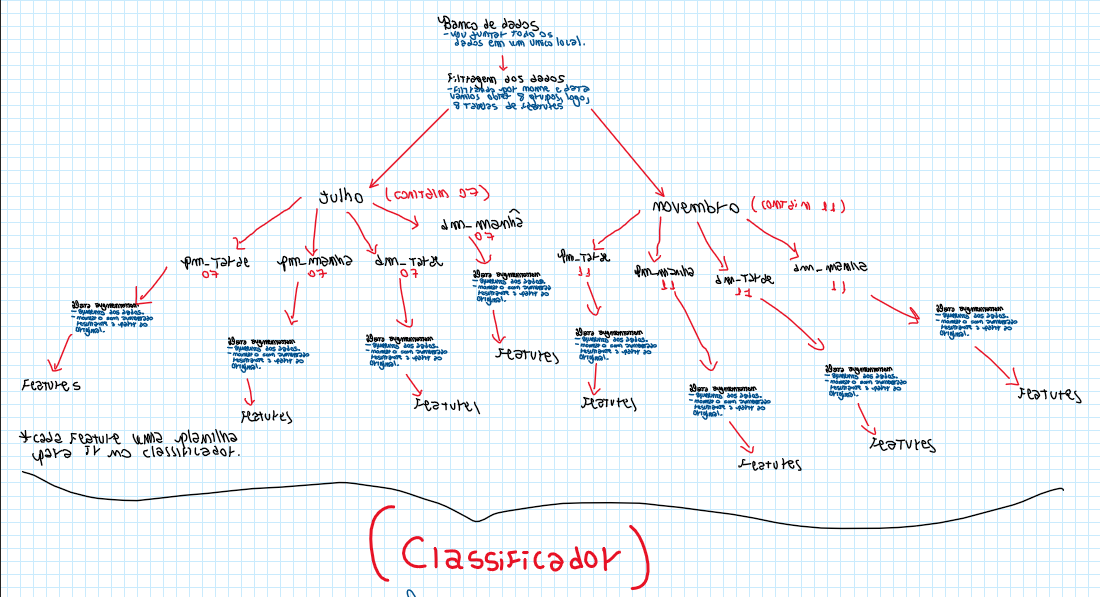

### 🔊 Defining functions for feature extraction:

- Assuming default sample rate for .wav of 44100 Hz
- Mean FFTs (Fast Fourier Transform)
- Max FFT’s (Fast Fourier Transform)
- Loudness
- Envelopes - five histograms of data
- Roughness
- Sharpness
- Spectrogram

**PT-BR: Definindo funções para extração de features**
- Média FFT’s (Transformada rápida de Fourier)
- Máxima FFT’s (Transformada rápida de Fourier)
- Sonoridade (loudness)
- Envelopes – cinco histogramas de dados
- Rugosidade
- Nitidez
- Espectrograma



In [ ]:
# definir frequencia max da fft
def maxfreq_fft(audio):
  len_audio = len(audio)
  fs = 44100
  SAMPLE_RATE = 1/fs
  tempo = np.linspace(0,len_audio/fs,len_audio)
  DURATION = tempo[len_audio-1]
  # Number of samples in normalized_tone
  N = int(DURATION / SAMPLE_RATE)
  yf = rfft(audio)
  xf = rfftfreq(N, SAMPLE_RATE)
  max_pos = np.array(np.abs(yf)).argmax()
  return max_pos

# loudness
def loud1(audio):
  # peak normalize audio to -1 dB
  peak_normalized_audio = pyln.normalize.peak(audio, -1.0)
  # measure the loudness first
  meter = pyln.Meter(44100) # create BS.1770 meter
  loudness = meter.integrated_loudness(audio)
  # loudness normalize audio to -12 dB LUFS
  loudness_normalized_audio = pyln.normalize.loudness(audio, loudness, -12.0)
  return loudness_normalized_audio

# espectrograma
def spect(audio):
  fs = 44100
  f, t, Sxx = signal.spectrogram(audio, fs)
  ind = np.unravel_index(np.argmax(Sxx, axis=None), Sxx.shape)
  feature3 = ind[1]/len(t)
  return feature3

#M. Glesser, S. Wanty, K. Degrendele, J. L. Besnerais, and S. Ni, “Perceived sound quality analysis of Electric
#Drive Units under different switching control strategies,” in 12th Aachen Acoustic Colloquium, Aachen, Nov. 2021.
#
# loudness
def loud2(audio):
  fs = 44100
  N, N_specific, bark_axis = loudness_zwst(audio, fs, field_type="free")
  return N

def sharp(audio):
  fs = 44100
  sharpness = sharpness_din_st(audio, fs, weighting="din")
  return sharpness

def roughness_(audio):
  fs = 44100
  # Compute multiple spectra along time
  r, r_spec, bark, time = roughness_dw(audio, fs, overlap=0)
  rough = sum(r)/len(audio)*10e5
  return rough

# tonalidade

def TNR_(audio):
  fs = 44100
  # Tone-to-noise Ratio calculation
  t_tnr, tnr, prom, tones_freq = tnr_ecma_st(audio, fs, prominence=True)
  print(t_tnr)
  print(tones_freq)
  return t_tnr, tones_freq

def PR_(audio):
  fs = 44100
  # Prominence Ratio calculation
  t_pr, pr, prom, tones_freq = pr_ecma_st(audio, fs, prominence=True)
  print(t_pr)
  print(tones_freq)
  return t_pr, tones_freq

In [ ]:
def envelope(audio, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """
    dmin=274
    dmax=274
    fs = 44100
    len_audio = len(audio)
    tempo = np.linspace(0,len_audio/fs,len_audio)
     # locals min
    lmin = (np.diff(np.sign(np.diff(audio))) > 0).nonzero()[0] + 1
    # locals max
    lmax = (np.diff(np.sign(np.diff(audio))) < 0).nonzero()[0] + 1
    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(audio)
        # pre-sorting of locals min based on relative position with respect to s_mid
        lmin = lmin[audio[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid
        lmax = lmax[audio[lmax]>s_mid]
    # global min of dmin-chunks of locals min
    lmin = lmin[[i+np.argmin(audio[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global max of dmax-chunks of locals max
    lmax = lmax[[i+np.argmax(audio[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    LW = audio[lmin]
    UP = audio[lmax]
    return (UP-LW)/2

# definir histograma envelope

def hist_envelope(audio):
  ENV = envelope(audio)
  hist, bin_edges = np.histogram(ENV, bins=5)
  return hist, bin_edges




# Julho


manha


pm


In [ ]:
# Definir o diretório onde estão os arquivos de áudio
diretorio_sons = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/banco_de_dados/bezerro_julho/manha/pm_manha_julho_aumentado"

# Lista para armazenar os dados
dados = []

In [ ]:
# Percorrer todos os arquivos de som no diretório
for diretorio_raiz, diretorios, arquivos in os.walk(diretorio_sons):
    for arquivo in arquivos:
        if arquivo.endswith(".wav"):  # Verificar se é um arquivo de áudio WAV (você pode alterar o formato se necessário)
            caminho_completo = os.path.join(diretorio_raiz, arquivo)

            # Processar o áudio usando a biblioteca librosa
            audio, sr = librosa.load(caminho_completo, sr=48000)
            frequencias = np.abs(librosa.core.stft(audio))
            media_frequencias = np.mean(frequencias)
            mf = maxfreq_fft(audio)
            hist_, bin_ = hist_envelope(audio)
            h1 = hist_[0]#hist1_envelope(audio)
            h2 = hist_[1]#hist2_envelope(audio)
            h3 = hist_[2]#hist3_envelope(audio)
            h4 = hist_[3]#hist4_envelope(audio)
            h5 = hist_[4]#hist5_envelope(audio)
            loud = loud2(audio)
            roug = roughness_(audio)
            #print(roug)
            #t_tnr, tones_tnr = TNR_(audio)
            #t_pr, tones_pr=PR_(audio)
            sp = sharp(audio)
            #print(sp)
            spec = spect(audio)
            #print(sp)
            #break
            # Adicionar os dados à lista
            dados.append({"Arquivo": arquivo, "Média Frequência (FFT)": media_frequencias,"Max Frequência (FFT)": mf, "loudness": loud, "hist1_envelope": h1, "hist2_envelope": h2, "hist3_envelope": h3, "hist4_envelope": h4, "hist5_envelope": h5, "Roughness": roug, "Sharpness": sp, "Spectrogram": spec})

In [ ]:
# Analisando o dataframe de saída das features:
print(dados)
df = pd.DataFrame(dados)
print(df)

[{'Arquivo': '61_pm_manha_1207.wav', 'Média Frequência (FFT)': 0.33938164, 'Max Frequência (FFT)': 722, 'loudness': 19.24, 'hist1_envelope': 6, 'hist2_envelope': 0, 'hist3_envelope': 3, 'hist4_envelope': 3, 'hist5_envelope': 6, 'Roughness': 40.55464832302719, 'Sharpness': 1.3505489823404326, 'Spectrogram': 0.5737704918032787}, {'Arquivo': 'time_shifted_61_pm_manha_1207.wav', 'Média Frequência (FFT)': 0.33860946, 'Max Frequência (FFT)': 722, 'loudness': 19.21, 'hist1_envelope': 6, 'hist2_envelope': 1, 'hist3_envelope': 2, 'hist4_envelope': 3, 'hist5_envelope': 6, 'Roughness': 39.9325554716695, 'Sharpness': 1.3463714487244547, 'Spectrogram': 0.5732899022801303}, {'Arquivo': 'pitch_shifted_61_pm_manha_1207.wav', 'Média Frequência (FFT)': 0.33499193, 'Max Frequência (FFT)': 722, 'loudness': 18.7, 'hist1_envelope': 6, 'hist2_envelope': 0, 'hist3_envelope': 3, 'hist4_envelope': 3, 'hist5_envelope': 6, 'Roughness': 32.91642578706658, 'Sharpness': 1.3231122590805962, 'Spectrogram': 0.585139318

In [ ]:
# Planilha com as features
df = pd.DataFrame(dados)

# Caminho para salvar na pasta "features para classificação"
caminho_arquivo = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/features_para_classificacao/features_julho_manha_pm.xlsx"

# Salvar o DataFrame em um arquivo XLSX
df.to_excel(caminho_arquivo, index=False)

#Julho

manha

dm

In [ ]:
# Definir o diretório onde estão os arquivos de áudio
diretorio_sons = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/banco_de_dados/bezerro_julho/manha/dm_manha_julho_aumentado"

# Lista para armazenar os dados
dados = []

In [ ]:
# Percorrer todos os arquivos de som no diretório
for diretorio_raiz, diretorios, arquivos in os.walk(diretorio_sons):
    for arquivo in arquivos:
        if arquivo.endswith(".wav"):  # Verificar se é um arquivo de áudio WAV (você pode alterar o formato se necessário)
            caminho_completo = os.path.join(diretorio_raiz, arquivo)

            # Processar o áudio usando a biblioteca librosa
            audio, sr = librosa.load(caminho_completo, sr=48000)
            frequencias = np.abs(librosa.core.stft(audio))
            media_frequencias = np.mean(frequencias)
            mf = maxfreq_fft(audio)
            hist_, bin_ = hist_envelope(audio)
            h1 = hist_[0]#hist1_envelope(audio)
            h2 = hist_[1]#hist2_envelope(audio)
            h3 = hist_[2]#hist3_envelope(audio)
            h4 = hist_[3]#hist4_envelope(audio)
            h5 = hist_[4]#hist5_envelope(audio)
            loud = loud2(audio)
            roug = roughness_(audio)
            #print(roug)
            #t_tnr, tones_tnr = TNR_(audio)
            #t_pr, tones_pr=PR_(audio)
            sp = sharp(audio)
            #print(sp)
            spec = spect(audio)
            #print(sp)
            #break
            # Adicionar os dados à lista
            dados.append({"Arquivo": arquivo, "Média Frequência (FFT)": media_frequencias,"Max Frequência (FFT)": mf, "loudness": loud, "hist1_envelope": h1, "hist2_envelope": h2, "hist3_envelope": h3, "hist4_envelope": h4, "hist5_envelope": h5, "Roughness": roug, "Sharpness": sp, "Spectrogram": spec})

In [ ]:
# Analisando o dataframe de saída das features:
print(dados)
df = pd.DataFrame(dados)
print(df)

[{'Arquivo': '61_dm_manha_0507.wav', 'Média Frequência (FFT)': 0.07437975, 'Max Frequência (FFT)': 1109, 'loudness': 7.812, 'hist1_envelope': 3, 'hist2_envelope': 1, 'hist3_envelope': 1, 'hist4_envelope': 1, 'hist5_envelope': 3, 'Roughness': 2.6972223247541773, 'Sharpness': 1.2441459889961646, 'Spectrogram': 0.2606060606060606}, {'Arquivo': 'time_shifted_61_dm_manha_0507.wav', 'Média Frequência (FFT)': 0.07401307, 'Max Frequência (FFT)': 1109, 'loudness': 7.799, 'hist1_envelope': 3, 'hist2_envelope': 2, 'hist3_envelope': 0, 'hist4_envelope': 0, 'hist5_envelope': 4, 'Roughness': 2.6191859086720437, 'Sharpness': 1.2352980550856327, 'Spectrogram': 0.2634730538922156}, {'Arquivo': 'pitch_shifted_61_dm_manha_0507.wav', 'Média Frequência (FFT)': 0.07736147, 'Max Frequência (FFT)': 1109, 'loudness': 8.248, 'hist1_envelope': 3, 'hist2_envelope': 1, 'hist3_envelope': 0, 'hist4_envelope': 0, 'hist5_envelope': 4, 'Roughness': 3.2629455957529916, 'Sharpness': 1.346316374243297, 'Spectrogram': 0.25

In [ ]:
# Planilha com as features
df = pd.DataFrame(dados)

# Caminho para salvar na pasta "features para classificação"
caminho_arquivo = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/features_para_classificacao/features_julho_manha_dm.xlsx"

# Salvar o DataFrame em um arquivo XLSX
df.to_excel(caminho_arquivo, index=False)

#Julho

tarde

pm

In [ ]:
# Definir o diretório onde estão os arquivos de áudio
diretorio_sons = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/banco_de_dados/bezerro_julho/tarde/pm_tarde_julho_aumentado"

# Lista para armazenar os dados
dados = []

In [ ]:
# Percorrer todos os arquivos de som no diretório
for diretorio_raiz, diretorios, arquivos in os.walk(diretorio_sons):
    for arquivo in arquivos:
        if arquivo.endswith(".wav"):  # Verificar se é um arquivo de áudio WAV (você pode alterar o formato se necessário)
            caminho_completo = os.path.join(diretorio_raiz, arquivo)

            # Processar o áudio usando a biblioteca librosa
            audio, sr = librosa.load(caminho_completo, sr=48000)
            frequencias = np.abs(librosa.core.stft(audio))
            media_frequencias = np.mean(frequencias)
            mf = maxfreq_fft(audio)
            hist_, bin_ = hist_envelope(audio)
            h1 = hist_[0]#hist1_envelope(audio)
            h2 = hist_[1]#hist2_envelope(audio)
            h3 = hist_[2]#hist3_envelope(audio)
            h4 = hist_[3]#hist4_envelope(audio)
            h5 = hist_[4]#hist5_envelope(audio)
            loud = loud2(audio)
            roug = roughness_(audio)
            #print(roug)
            #t_tnr, tones_tnr = TNR_(audio)
            #t_pr, tones_pr=PR_(audio)
            sp = sharp(audio)
            #print(sp)
            spec = spect(audio)
            #print(sp)
            #break
            # Adicionar os dados à lista
            dados.append({"Arquivo": arquivo, "Média Frequência (FFT)": media_frequencias,"Max Frequência (FFT)": mf, "loudness": loud, "hist1_envelope": h1, "hist2_envelope": h2, "hist3_envelope": h3, "hist4_envelope": h4, "hist5_envelope": h5, "Roughness": roug, "Sharpness": sp, "Spectrogram": spec})

In [ ]:
# Analisando o dataframe de saída das features:
print(dados)
df = pd.DataFrame(dados)
print(df)

[{'Arquivo': '58_pm_tarde_290622.wav', 'Média Frequência (FFT)': 0.5971584, 'Max Frequência (FFT)': 650, 'loudness': 27.41, 'hist1_envelope': 6, 'hist2_envelope': 0, 'hist3_envelope': 1, 'hist4_envelope': 2, 'hist5_envelope': 8, 'Roughness': 14.686702006764694, 'Sharpness': 1.448617098452341, 'Spectrogram': 0.5498392282958199}, {'Arquivo': 'time_shifted_58_pm_tarde_290622.wav', 'Média Frequência (FFT)': 0.595779, 'Max Frequência (FFT)': 650, 'loudness': 27.27, 'hist1_envelope': 5, 'hist2_envelope': 1, 'hist3_envelope': 1, 'hist4_envelope': 2, 'hist5_envelope': 8, 'Roughness': 14.76443760756198, 'Sharpness': 1.437464111273711, 'Spectrogram': 0.6044303797468354}, {'Arquivo': 'pitch_shifted_58_pm_tarde_290622.wav', 'Média Frequência (FFT)': 0.6067056, 'Max Frequência (FFT)': 650, 'loudness': 28.0, 'hist1_envelope': 5, 'hist2_envelope': 1, 'hist3_envelope': 1, 'hist4_envelope': 2, 'hist5_envelope': 8, 'Roughness': 13.178074626499246, 'Sharpness': 1.4826465036050862, 'Spectrogram': 0.539249

In [ ]:
# Planilha com as features
df = pd.DataFrame(dados)

# Caminho para salvar na pasta "features para classificação"
caminho_arquivo = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/features_para_classificacao/features_julho_tarde_pm.xlsx"

# Salvar o DataFrame em um arquivo XLSX
df.to_excel(caminho_arquivo, index=False)

#Julho

tarde

dm

In [ ]:
# Definir o diretório onde estão os arquivos de áudio
diretorio_sons = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/banco_de_dados/bezerro_julho/tarde/dm_tarde_julho_aumentado"

# Lista para armazenar os dados
dados = []

In [ ]:
# Percorrer todos os arquivos de som no diretório
for diretorio_raiz, diretorios, arquivos in os.walk(diretorio_sons):
    for arquivo in arquivos:
        if arquivo.endswith(".wav"):  # Verificar se é um arquivo de áudio WAV (você pode alterar o formato se necessário)
            caminho_completo = os.path.join(diretorio_raiz, arquivo)

            # Processar o áudio usando a biblioteca librosa
            audio, sr = librosa.load(caminho_completo, sr=48000)
            frequencias = np.abs(librosa.core.stft(audio))
            media_frequencias = np.mean(frequencias)
            mf = maxfreq_fft(audio)
            hist_, bin_ = hist_envelope(audio)
            h1 = hist_[0]#hist1_envelope(audio)
            h2 = hist_[1]#hist2_envelope(audio)
            h3 = hist_[2]#hist3_envelope(audio)
            h4 = hist_[3]#hist4_envelope(audio)
            h5 = hist_[4]#hist5_envelope(audio)
            loud = loud2(audio)
            roug = roughness_(audio)
            #print(roug)
            #t_tnr, tones_tnr = TNR_(audio)
            #t_pr, tones_pr=PR_(audio)
            sp = sharp(audio)
            #print(sp)
            spec = spect(audio)
            #print(sp)
            #break
            # Adicionar os dados à lista
            dados.append({"Arquivo": arquivo, "Média Frequência (FFT)": media_frequencias,"Max Frequência (FFT)": mf, "loudness": loud, "hist1_envelope": h1, "hist2_envelope": h2, "hist3_envelope": h3, "hist4_envelope": h4, "hist5_envelope": h5, "Roughness": roug, "Sharpness": sp, "Spectrogram": spec})

In [ ]:
# Analisando o dataframe de saída das features:
print(dados)
df = pd.DataFrame(dados)
print(df)

[{'Arquivo': '57_dm_tarde_060722_varios.wav', 'Média Frequência (FFT)': 0.11444518, 'Max Frequência (FFT)': 1319, 'loudness': 9.658, 'hist1_envelope': 21, 'hist2_envelope': 12, 'hist3_envelope': 8, 'hist4_envelope': 5, 'hist5_envelope': 5, 'Roughness': 9.417763782424295, 'Sharpness': 1.4271404295636458, 'Spectrogram': 0.7655172413793103}, {'Arquivo': 'time_shifted_57_dm_tarde_060722_varios.wav', 'Média Frequência (FFT)': 0.113962814, 'Max Frequência (FFT)': 1319, 'loudness': 9.645, 'hist1_envelope': 19, 'hist2_envelope': 17, 'hist3_envelope': 5, 'hist4_envelope': 7, 'hist5_envelope': 2, 'Roughness': 9.276618725915702, 'Sharpness': 1.422388707128658, 'Spectrogram': 0.6866438356164384}, {'Arquivo': 'pitch_shifted_57_dm_tarde_060722_varios.wav', 'Média Frequência (FFT)': 0.11153578, 'Max Frequência (FFT)': 1319, 'loudness': 9.558, 'hist1_envelope': 21, 'hist2_envelope': 12, 'hist3_envelope': 8, 'hist4_envelope': 6, 'hist5_envelope': 4, 'Roughness': 9.29122379367282, 'Sharpness': 1.3919926

In [ ]:
# Planilha com as features
df = pd.DataFrame(dados)

# Caminho para salvar na pasta "features para classificação"
caminho_arquivo = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/features_para_classificacao/features_julho_tarde_dm.xlsx"

# Salvar o DataFrame em um arquivo XLSX
df.to_excel(caminho_arquivo, index=False)

#Novembro


manha

pm

In [ ]:
# Definir o diretório onde estão os arquivos de áudio
diretorio_sons = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/banco_de_dados/bezerro_novembro/manha/pm_manha_novembro_aumentado"

# Lista para armazenar os dados
dados = []

In [ ]:
# Percorrer todos os arquivos de som no diretório
for diretorio_raiz, diretorios, arquivos in os.walk(diretorio_sons):
    for arquivo in arquivos:
        if arquivo.endswith(".wav"):  # Verificar se é um arquivo de áudio WAV (você pode alterar o formato se necessário)
            caminho_completo = os.path.join(diretorio_raiz, arquivo)

            # Processar o áudio usando a biblioteca librosa
            audio, sr = librosa.load(caminho_completo, sr=48000)
            frequencias = np.abs(librosa.core.stft(audio))
            media_frequencias = np.mean(frequencias)
            mf = maxfreq_fft(audio)
            hist_, bin_ = hist_envelope(audio)
            h1 = hist_[0]#hist1_envelope(audio)
            h2 = hist_[1]#hist2_envelope(audio)
            h3 = hist_[2]#hist3_envelope(audio)
            h4 = hist_[3]#hist4_envelope(audio)
            h5 = hist_[4]#hist5_envelope(audio)
            loud = loud2(audio)
            roug = roughness_(audio)
            #print(roug)
            #t_tnr, tones_tnr = TNR_(audio)
            #t_pr, tones_pr=PR_(audio)
            sp = sharp(audio)
            #print(sp)
            spec = spect(audio)
            #print(sp)
            #break
            # Adicionar os dados à lista
            dados.append({"Arquivo": arquivo, "Média Frequência (FFT)": media_frequencias,"Max Frequência (FFT)": mf, "loudness": loud, "hist1_envelope": h1, "hist2_envelope": h2, "hist3_envelope": h3, "hist4_envelope": h4, "hist5_envelope": h5, "Roughness": roug, "Sharpness": sp, "Spectrogram": spec})

In [ ]:
# Analisando o dataframe de saída das features:
print(dados)
df = pd.DataFrame(dados)
print(df)

[{'Arquivo': '57_pm_manha_251122_varios.wav', 'Média Frequência (FFT)': 0.35789436, 'Max Frequência (FFT)': 18707, 'loudness': 22.4, 'hist1_envelope': 167, 'hist2_envelope': 41, 'hist3_envelope': 37, 'hist4_envelope': 5, 'hist5_envelope': 6, 'Roughness': 48.847178399045355, 'Sharpness': 1.2954803534796029, 'Spectrogram': 0.9300411522633745}, {'Arquivo': 'time_shifted_57_pm_manha_251122_varios.wav', 'Média Frequência (FFT)': 0.35716903, 'Max Frequência (FFT)': 18707, 'loudness': 22.32, 'hist1_envelope': 168, 'hist2_envelope': 39, 'hist3_envelope': 40, 'hist4_envelope': 4, 'hist5_envelope': 6, 'Roughness': 47.11941161098787, 'Sharpness': 1.287959804240834, 'Spectrogram': 0.9304038608077216}, {'Arquivo': 'pitch_shifted_57_pm_manha_251122_varios.wav', 'Média Frequência (FFT)': 0.36594304, 'Max Frequência (FFT)': 18707, 'loudness': 22.83, 'hist1_envelope': 161, 'hist2_envelope': 38, 'hist3_envelope': 39, 'hist4_envelope': 4, 'hist5_envelope': 7, 'Roughness': 40.95256359048845, 'Sharpness': 

In [ ]:
# Planilha com as features
df = pd.DataFrame(dados)

# Caminho para salvar na pasta "features para classificação"
caminho_arquivo = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/features_para_classificacao/features_novembro_manha_pm.xlsx"

# Salvar o DataFrame em um arquivo XLSX
df.to_excel(caminho_arquivo, index=False)

#Novembro


manha

dm

In [ ]:
# Definir o diretório onde estão os arquivos de áudio
diretorio_sons = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/banco_de_dados/bezerro_novembro/manha/dm_manha_novembro_aumentado"

# Lista para armazenar os dados
dados = []

In [ ]:
# Percorrer todos os arquivos de som no diretório
for diretorio_raiz, diretorios, arquivos in os.walk(diretorio_sons):
    for arquivo in arquivos:
        if arquivo.endswith(".wav"):  # Verificar se é um arquivo de áudio WAV (você pode alterar o formato se necessário)
            caminho_completo = os.path.join(diretorio_raiz, arquivo)

            # Processar o áudio usando a biblioteca librosa
            audio, sr = librosa.load(caminho_completo, sr=48000)
            frequencias = np.abs(librosa.core.stft(audio))
            media_frequencias = np.mean(frequencias)
            mf = maxfreq_fft(audio)
            hist_, bin_ = hist_envelope(audio)
            h1 = hist_[0]#hist1_envelope(audio)
            h2 = hist_[1]#hist2_envelope(audio)
            h3 = hist_[2]#hist3_envelope(audio)
            h4 = hist_[3]#hist4_envelope(audio)
            h5 = hist_[4]#hist5_envelope(audio)
            loud = loud2(audio)
            roug = roughness_(audio)
            #print(roug)
            #t_tnr, tones_tnr = TNR_(audio)
            #t_pr, tones_pr=PR_(audio)
            sp = sharp(audio)
            #print(sp)
            spec = spect(audio)
            #print(sp)
            #break
            # Adicionar os dados à lista
            dados.append({"Arquivo": arquivo, "Média Frequência (FFT)": media_frequencias,"Max Frequência (FFT)": mf, "loudness": loud, "hist1_envelope": h1, "hist2_envelope": h2, "hist3_envelope": h3, "hist4_envelope": h4, "hist5_envelope": h5, "Roughness": roug, "Sharpness": sp, "Spectrogram": spec})

ValueError: ignored

In [ ]:
# Analisando o dataframe de saída das features:
print(dados)
df = pd.DataFrame(dados)
print(df)

In [ ]:
# Planilha com as features
df = pd.DataFrame(dados)

# Caminho para salvar na pasta "features para classificação"
caminho_arquivo = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/features_para_classificacao/features_novembro_manha_dm.xlsx"

# Salvar o DataFrame em um arquivo XLSX
df.to_excel(caminho_arquivo, index=False)

#Novembro

tarde

pm

In [ ]:
# Definir o diretório onde estão os arquivos de áudio
diretorio_sons = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/banco_de_dados/bezerro_novembro/tarde/pm_tarde_julho_aumentado"

# Lista para armazenar os dados
dados = []

In [ ]:
# Percorrer todos os arquivos de som no diretório
for diretorio_raiz, diretorios, arquivos in os.walk(diretorio_sons):
    for arquivo in arquivos:
        if arquivo.endswith(".wav"):  # Verificar se é um arquivo de áudio WAV (você pode alterar o formato se necessário)
            caminho_completo = os.path.join(diretorio_raiz, arquivo)

            # Processar o áudio usando a biblioteca librosa
            audio, sr = librosa.load(caminho_completo, sr=48000)
            frequencias = np.abs(librosa.core.stft(audio))
            media_frequencias = np.mean(frequencias)
            mf = maxfreq_fft(audio)
            hist_, bin_ = hist_envelope(audio)
            h1 = hist_[0]#hist1_envelope(audio)
            h2 = hist_[1]#hist2_envelope(audio)
            h3 = hist_[2]#hist3_envelope(audio)
            h4 = hist_[3]#hist4_envelope(audio)
            h5 = hist_[4]#hist5_envelope(audio)
            loud = loud2(audio)
            roug = roughness_(audio)
            #print(roug)
            #t_tnr, tones_tnr = TNR_(audio)
            #t_pr, tones_pr=PR_(audio)
            sp = sharp(audio)
            #print(sp)
            spec = spect(audio)
            #print(sp)
            #break
            # Adicionar os dados à lista
            dados.append({"Arquivo": arquivo, "Média Frequência (FFT)": media_frequencias,"Max Frequência (FFT)": mf, "loudness": loud, "hist1_envelope": h1, "hist2_envelope": h2, "hist3_envelope": h3, "hist4_envelope": h4, "hist5_envelope": h5, "Roughness": roug, "Sharpness": sp, "Spectrogram": spec})

In [ ]:
# Analisando o dataframe de saída das features:
print(dados)
df = pd.DataFrame(dados)
print(df)

[]
Empty DataFrame
Columns: []
Index: []


In [ ]:
# Planilha com as features
df = pd.DataFrame(dados)

# Caminho para salvar na pasta "features para classificação"
caminho_arquivo = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/features_para_classificacao/features_novembro_tarde_pm.xlsx"

# Salvar o DataFrame em um arquivo XLSX
df.to_excel(caminho_arquivo, index=False)

#Novembro

tarde

dm

In [ ]:
# Definir o diretório onde estão os arquivos de áudio
diretorio_sons = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/banco_de_dados/bezerro_novembro/tarde/dm_tarde_julho_aumentado"

# Lista para armazenar os dados
dados = []

In [ ]:
# Percorrer todos os arquivos de som no diretório
for diretorio_raiz, diretorios, arquivos in os.walk(diretorio_sons):
    for arquivo in arquivos:
        if arquivo.endswith(".wav"):  # Verificar se é um arquivo de áudio WAV (você pode alterar o formato se necessário)
            caminho_completo = os.path.join(diretorio_raiz, arquivo)

            # Processar o áudio usando a biblioteca librosa
            audio, sr = librosa.load(caminho_completo, sr=48000)
            frequencias = np.abs(librosa.core.stft(audio))
            media_frequencias = np.mean(frequencias)
            mf = maxfreq_fft(audio)
            hist_, bin_ = hist_envelope(audio)
            h1 = hist_[0]#hist1_envelope(audio)
            h2 = hist_[1]#hist2_envelope(audio)
            h3 = hist_[2]#hist3_envelope(audio)
            h4 = hist_[3]#hist4_envelope(audio)
            h5 = hist_[4]#hist5_envelope(audio)
            loud = loud2(audio)
            roug = roughness_(audio)
            #print(roug)
            #t_tnr, tones_tnr = TNR_(audio)
            #t_pr, tones_pr=PR_(audio)
            sp = sharp(audio)
            #print(sp)
            spec = spect(audio)
            #print(sp)
            #break
            # Adicionar os dados à lista
            dados.append({"Arquivo": arquivo, "Média Frequência (FFT)": media_frequencias,"Max Frequência (FFT)": mf, "loudness": loud, "hist1_envelope": h1, "hist2_envelope": h2, "hist3_envelope": h3, "hist4_envelope": h4, "hist5_envelope": h5, "Roughness": roug, "Sharpness": sp, "Spectrogram": spec})

In [ ]:
# Analisando o dataframe de saída das features:
print(dados)
df = pd.DataFrame(dados)
print(df)

In [ ]:
# Planilha com as features
df = pd.DataFrame(dados)

# Caminho para salvar na pasta "features para classificação"
caminho_arquivo = "/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/features_para_classificacao/features_novembro_tarde_dm.xlsx"

# Salvar o DataFrame em um arquivo XLSX
df.to_excel(caminho_arquivo, index=False)